In [1]:
import numpy as np
import swift_scrape
import os
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import math
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_flux.txt'
GRBs=["050724","060614","070714B","150424A","211211A","211227A","061210","071227"]

### Extracting and Plotting Curves


In [ ]:
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.7)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(3, 3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

#### GRB i=2

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 359
    # data points      = 21
    # variables        = 4
    chi-square         = 7.30130912
    reduced chi-square = 0.42948877
    Akaike info crit   = -14.1858443
    Bayesian info crit = -10.0077545
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    t_break:    1021.84211 (init = 1000)
    alpha_1:   -6.3397e-11 (init = -0.009)
    alpha_2:    1.59165264 (init = 1.6)
    amplitude:  2.7770e-11 (init = 3.5e-11)


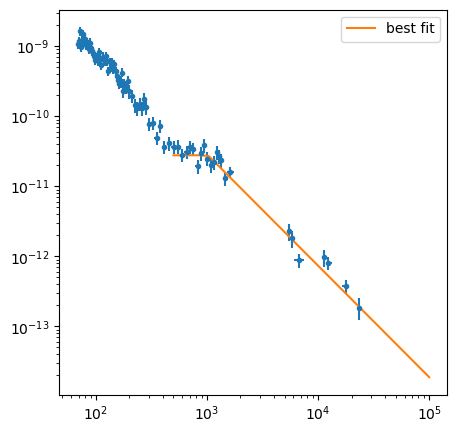

In [23]:
i=2
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 62
params=lm.Parameters()
params.add("t_break", min = 5e2, max = 5e3, value = 1e3)
params.add("alpha_1", min = -1, max = 0, value = -0.009)
params.add("alpha_2", min = 0.0, max = 3.0, value = 1.6)
params.add("amplitude", min = 1e-11, max = 1e-10, value = 3.5e-11)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="nelder")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

print(lm.fit_report(result))

x1=np.geomspace(5e2,1e5,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
plt.yscale("log")
plt.xscale("log")
#plt.plot(time[fit_index:], flux[fit_index:],"o")
plt.legend()
plt.show()

In [4]:
res_refined = lm.minimize(cost_func_bpl, method='emcee', burn=1000, steps=50000,
                            params=bfit, is_weighted=True, args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]),
                            nwalkers = 100)

100%|██████████| 50000/50000 [01:40<00:00, 497.14it/s]


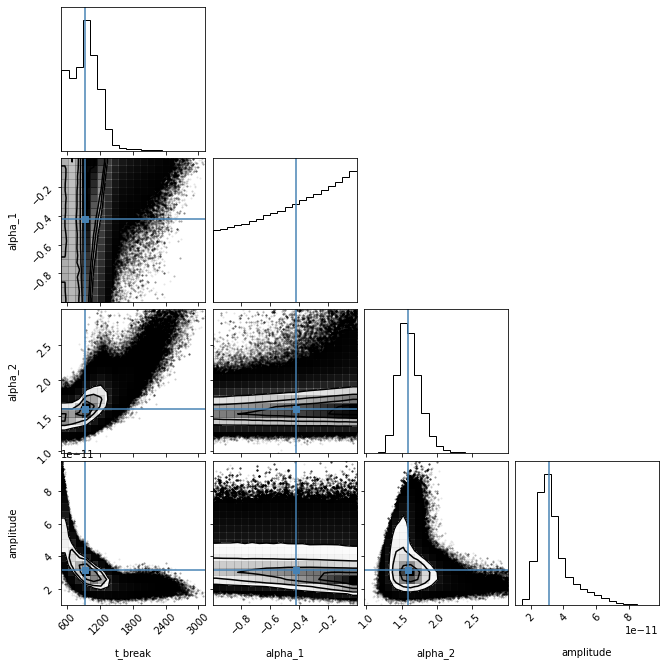

In [6]:
emcee_plot = corner.corner(res_refined.flatchain, labels=res_refined.var_names,
                           truths=list((res_refined.params.valuesdict().values())))                       

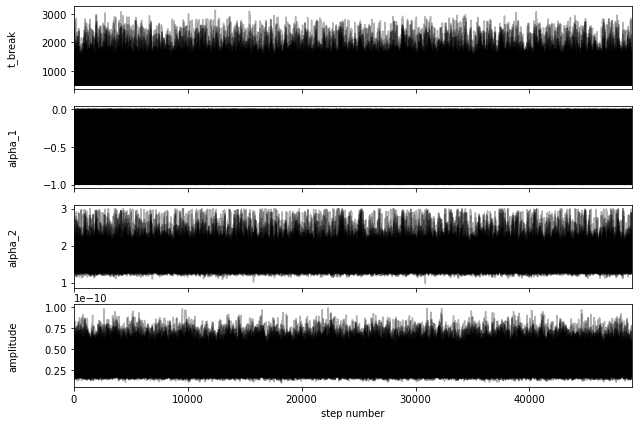

In [7]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = res_refined.chain
labels=res_refined.var_names
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


### Initial Emission

In [3]:
i=2
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 60
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 2)
params_ini.add("amplitude", min = 1e-6, max = 1, value = 3e-6)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="least_squares")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(60,550,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
# plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
plt.plot(x1,power_law(x1, 2.5, 1e-4),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

NameError: name 'time' is not defined

<Figure size 800x800 with 0 Axes>

In [39]:
res_refined_ini = lm.minimize(cost_func_pl, method='emcee', burn=1000, steps=5000,
                            params=bfit_ini, is_weighted=True, args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]),nwalkers = 100)

100%|██████████| 5000/5000 [00:10<00:00, 485.62it/s]


{'alpha_1': 1.8690960314907321, 'amplitude': 4.122366388254891e-06}

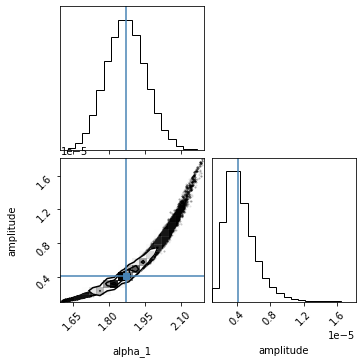

In [40]:
emcee_plot = corner.corner(res_refined_ini.flatchain, labels=res_refined_ini.var_names,
                           truths=list((res_refined_ini.params.valuesdict().values())))

res_refined_ini.params.valuesdict()

In [ ]:
df = pd.read_csv("grb_bpl.csv")
pd_row = res_refined.params.valuesdict()
pd_row["GRB Name"] = GRBs[i]
pd_row["GRB Index"] = i
df.iloc[i] = pd_row
df.to_csv("grb_bpl.csv",index=False)

df2 = pd.read_csv("grb_initial_pl.csv")
pd_row2 = res_refined_ini.params.valuesdict()
pd_row2["GRB Name"] = GRBs[i]
pd_row2["GRB Index"] = i
df2.iloc[i] = pd_row2
df2.to_csv("grb_initial_pl.csv",index=False)

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 177
    # data points      = 83
    # variables        = 10
    chi-square         = 19.8781447
    reduced chi-square = 0.27230335
    Akaike info crit   = -98.6252381
    Bayesian info crit = -74.4368320
[[Variables]]
    tb0:        108.567739 +/- 26.6727761 (24.57%) (init = 100)
    tb1:        140.148984 +/- 13.3824162 (9.55%) (init = 150)
    tb2:        482.599820 +/- 45.2179687 (9.37%) (init = 400)
    tb3:        963.993173 +/- 104.563640 (10.85%) (init = 1000)
    alpha_0:    1.51878528 +/- 0.25139875 (16.55%) (init = 2)
    alpha_1:    1.02730331 +/- 0.69814820 (67.96%) (init = 1)
    alpha_2:    2.29254590 +/- 0.11944170 (5.21%) (init = 3)
    alpha_3:   -2.3853e-04 +/- 0.41329745 (173267.94%) (init = -0.2)
    alpha_4:    1.57826268 +/- 0.06322225 (4.01%) (init = 1.5)
    amplitude:  6.5652e-10 +/- 2.2114e-10 (33.68%) (init = 8e-10)
[[Correlations]] (unreported correlations are < 0.100)
    

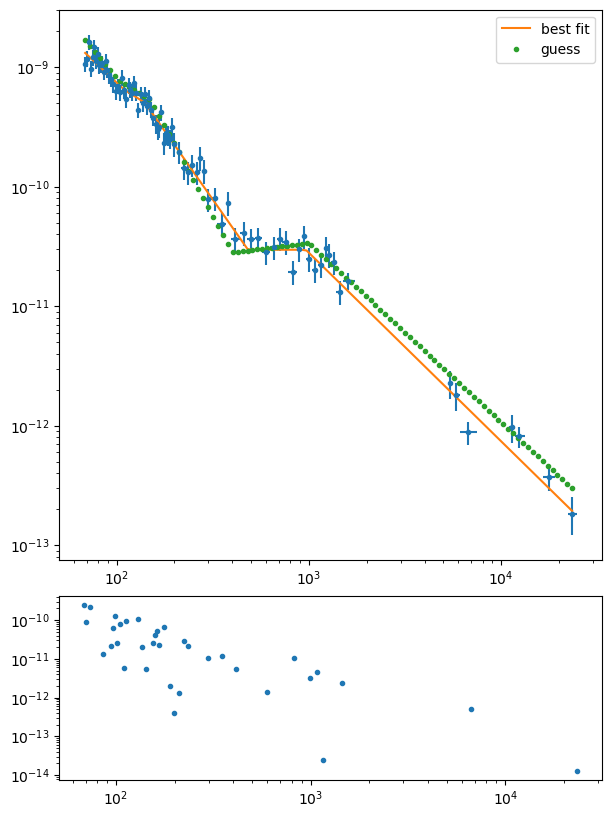

name,value,standard error,relative error,initial value,min,max,vary
tb0,108.567739,26.6727761,(24.57%),100.0,70.0000000,300.000000,True
tb1,140.148984,13.3824162,(9.55%),150.0,80.0000000,500.000000,True
tb2,482.599820,45.2179687,(9.37%),400.0,100.000000,900.000000,True
tb3,963.993173,104.563640,(10.85%),1000.0,500.000000,5000.00000,True
alpha_0,1.51878528,0.25139875,(16.55%),2.0,-10.0000000,10.0000000,True
alpha_1,1.02730331,0.69814820,(67.96%),1.0,-10.0000000,20.0000000,True
alpha_2,2.29254590,0.11944170,(5.21%),3,-100.000000,100.000000,True
alpha_3,-2.3853e-04,0.41329745,(173267.94%),-0.2,-5.00000000,0.00000000,True
alpha_4,1.57826268,0.06322225,(4.01%),1.5,0.00000000,10.0000000,True
amplitude,6.5652e-10,2.2114e-10,(33.68%),8e-10,1.0000e-10,5.0000e-09,True


In [95]:
i=2
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=5
params=lm.Parameters()
params.add("tb0", min = 7e1, max = 3e2, value = 1e2)
params.add("tb1", min = 8e1, max = 5e2, value = 1.5e2)
params.add("tb2", min = 1e2, max = 9e2, value = 4e2)
params.add("tb3", min = 5e2, max = 5e3, value = 1e3)
params.add("alpha_0", min = -10, max = 10.0, value = 2.0)
params.add("alpha_1", min = -10, max = 20.0, value = 1.0)
params.add("alpha_2", min = -100, max = 100, value = 3)
params.add("alpha_3", min = -5.0, max = 0, value = -0.2)
params.add("alpha_4", min = 0, max = 10.0, value = 1.5)
params.add("amplitude", min = 1e-10, max = 5e-9, value = 8e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 10), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [2.5e2, 5e2, 2e3, 1.5e4, 5.5e4], [2, 8.0, -0.2, 1.4, -2.2, 3.0], 8e-11),'.',label ='guess')
ax1.loglog(x, nbroken_law(x, [1e2, 1.5e2, 4e2, 1e3], [2, 1, 3, -0.2, 1.5], 8e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 189
    # data points      = 83
    # variables        = 6
    chi-square         = 26.5786784
    reduced chi-square = 0.34517764
    Akaike info crit   = -82.5146959
    Bayesian info crit = -68.0016523
[[Variables]]
    tb0:        544.398236 +/- 71.2219714 (13.08%) (init = 450)
    tb1:        1223.61900 +/- 213.861438 (17.48%) (init = 1000)
    alpha_0:    1.83322439 +/- 0.05005494 (2.73%) (init = 2)
    alpha_1:    0.50548709 +/- 0.31718090 (62.75%) (init = 0.2)
    alpha_2:    1.62877736 +/- 0.08950243 (5.50%) (init = 1.7)
    amplitude:  3.3490e-11 +/- 7.2556e-12 (21.66%) (init = 4e-11)
[[Correlations]] (unreported correlations are < 0.100)
    C(tb0, amplitude)     = -0.9474
    C(alpha_1, amplitude) = +0.8582
    C(tb0, alpha_1)       = -0.7752
    C(tb1, alpha_1)       = +0.6225
    C(tb1, alpha_2)       = +0.5248
    C(tb0, alpha_0)       = -0.4211
    C(tb1, amplitude)     = +0.3385
    C(tb

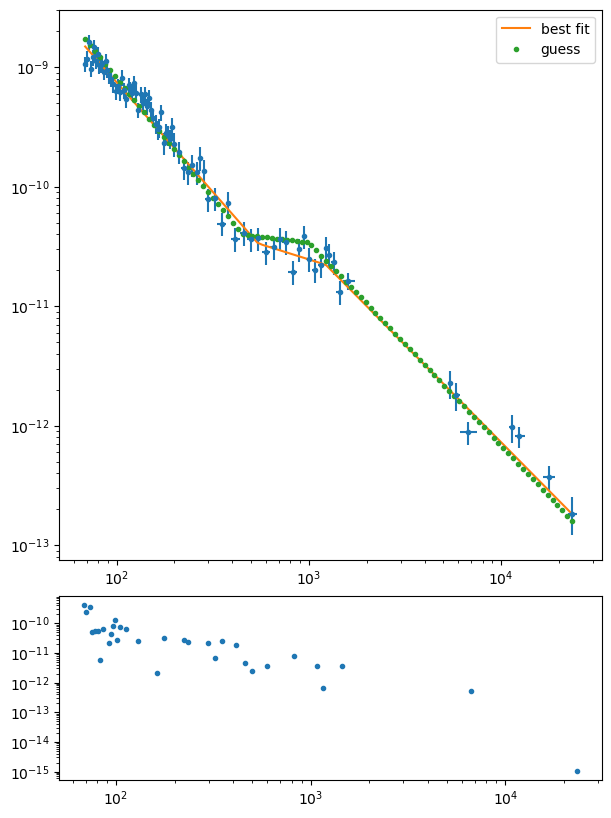

name,value,standard error,relative error,initial value,min,max,vary
tb0,544.398236,71.2219714,(13.08%),450.0,100.000000,900.000000,True
tb1,1223.61900,213.861438,(17.48%),1000.0,500.000000,5000.00000,True
alpha_0,1.83322439,0.05005494,(2.73%),2.0,-10.0000000,10.0000000,True
alpha_1,0.50548709,0.31718090,(62.75%),0.2,-5.00000000,5.00000000,True
alpha_2,1.62877736,0.08950243,(5.50%),1.7,0.00000000,10.0000000,True
amplitude,3.3490e-11,7.2556e-12,(21.66%),4e-11,1.0000e-11,1.0000e-10,True


In [94]:
i=2
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=3
params=lm.Parameters()
params.add("tb0", min = 1e2, max = 9e2, value = 4.5e2)
params.add("tb1", min = 5e2, max = 5e3, value = 1e3)
params.add("alpha_0", min = -10, max = 10.0, value = 2.0)
params.add("alpha_1", min = -5.0, max = 5, value = 0.2)
params.add("alpha_2", min = 0, max = 10.0, value = 1.7)
params.add("amplitude", min = 1e-11, max = 1e-10, value = 4e-11)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 10), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [2.5e2, 5e2, 2e3, 1.5e4, 5.5e4], [2, 8.0, -0.2, 1.4, -2.2, 3.0], 8e-11),'.',label ='guess')
ax1.loglog(x, nbroken_law(x, [4.5e2, 1e3], [2, 0.2, 1.7], 4e-11),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(hspace=0.1)
plt.show()

result.params